# Counterfactual explanations

A counterfactual explanation of a prediction describes the smallest change to the feature values that changes the prediction to a predefined output.  
This tool gives you the following benefits:  
1. Helps in understanding how, sometimes very sophisticated, model works
2. Presents how far we are from different output
3. It can assess the stability of model predictions and detect potential dangers  

Here I present some example of this concept on the Fashion-MNIST dataset.

## Loading necessary libraries

In [114]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from alibi.explainers import Counterfactual

import warnings
warnings.filterwarnings('ignore')


In [5]:
tf.compat.v1.disable_eager_execution() # for alibi compatibility

## Loading data

In [10]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [11]:
names_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

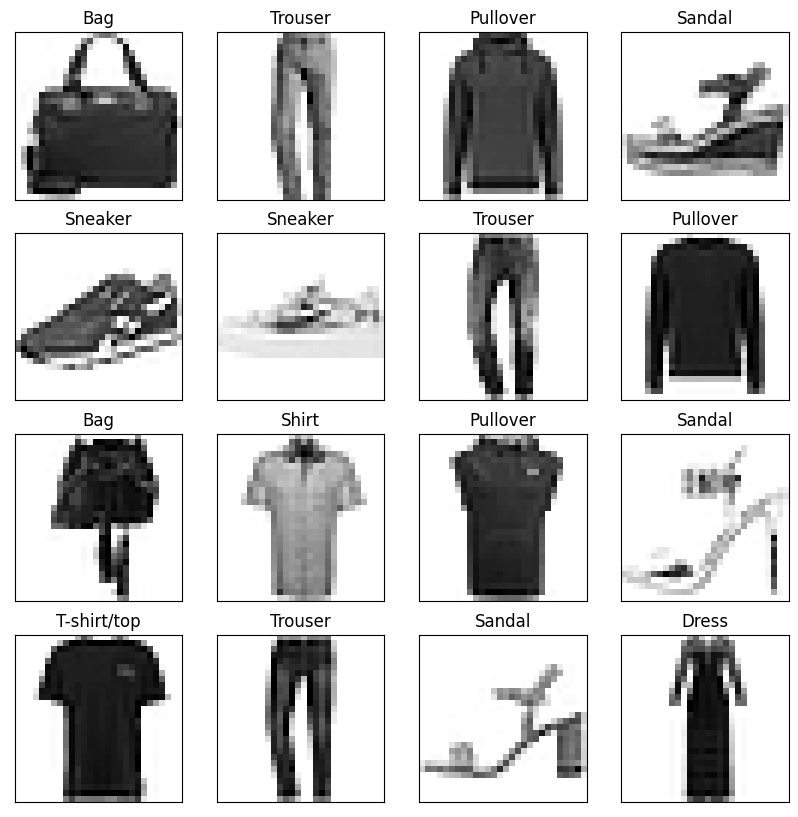

In [31]:
subset = np.random.choice(np.arange(6000), size=16)
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    label = np.where(train_labels[subset][i] == 1)[0][0]
    plt.imshow(train_images[subset][i], cmap=plt.cm.binary)
    plt.title(names_mapping[label])
plt.show()

## Simple network

In [181]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [182]:
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer="SGD", loss=loss, metrics=["accuracy"])

In [183]:
model.fit(train_images, train_labels, batch_size=128, epochs= 200)

Train on 60000 samples
Epoch 1/200
60000/60000 [==============================] - 1s 17us/sample - loss: 1.4775 - accuracy: 0.5007
Epoch 2/200
60000/60000 [==============================] - 1s 13us/sample - loss: 0.9481 - accuracy: 0.6729
Epoch 3/200
60000/60000 [==============================] - 1s 12us/sample - loss: 0.8133 - accuracy: 0.7264
Epoch 4/200
60000/60000 [==============================] - 1s 12us/sample - loss: 0.7311 - accuracy: 0.7540
Epoch 5/200
60000/60000 [==============================] - 1s 12us/sample - loss: 0.6801 - accuracy: 0.7726
Epoch 6/200
60000/60000 [==============================] - 1s 12us/sample - loss: 0.6425 - accuracy: 0.7839
Epoch 7/200
60000/60000 [==============================] - 1s 12us/sample - loss: 0.6166 - accuracy: 0.7929
Epoch 8/200
60000/60000 [==============================] - 1s 12us/sample - loss: 0.5957 - accuracy: 0.7997
Epoch 9/200
60000/60000 [==============================] - 1s 12us/sample - loss: 0.5770 - accuracy: 0.8056
Epoch

In [221]:
eval = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test results:\n loss: {eval[0]} accuracy: {eval[1]}")

Test results:
 loss: 0.3391598818600178 accuracy: 0.8841999769210815


## Getting counterfactual explanation

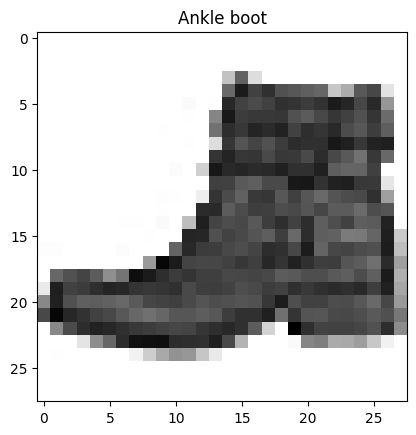

In [215]:
ex = np.random.randint(0, 6000)
X = test_images[ex].reshape((1,) + test_images[ex].shape)
plt.imshow(X.reshape(28, 28), cmap=plt.cm.binary)

label = np.where(test_labels[ex] == 1)[0][0]
name = names_mapping[label]
plt.title(name)

plt.show()

In [216]:
shape = (1,) + train_images.shape[1:]
target_proba = 1.0
tol = 0.01
target_class = "other"
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (train_images.min(), train_images.max())

In [217]:
cf = Counterfactual(model, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

explanation = cf.explain(X)

Counterfactual prediction: Sneaker with probability 0.9936000108718872


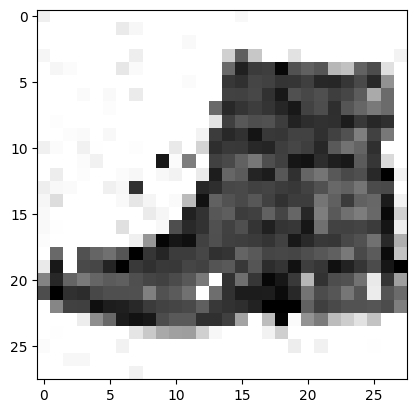

In [218]:
pred_class = explanation.cf['class']
proba = round(explanation.cf['proba'][0][pred_class], 4)

print(f"Counterfactual prediction: {names_mapping[pred_class]} with probability {proba}")
plt.imshow(explanation.cf['X'].reshape(28, 28), cmap=plt.cm.binary)
plt.show()

Now I can show which and how pixels has changed

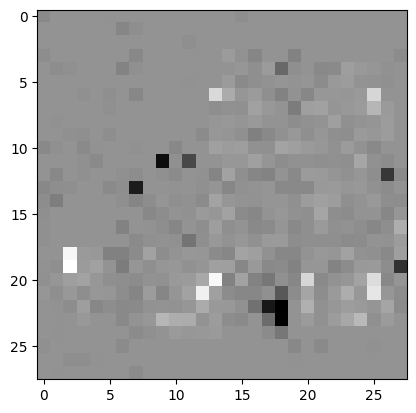

In [219]:
plt.imshow((explanation.cf['X']- X).reshape(28, 28), cmap=plt.cm.binary)
plt.show()

These pictures show how bad is the network, despite its high accuracy. The new input does not look like a sneaker at all. It seems that it's enough to add some random noise for model to fail. 